# HTML-Parsing
The first step in analysing the IAC abstracts is to download them from here: https://dl.iafastro.directory/search/?q=event%3AIAC-2022&o=2000&l=500&o=0


This is what the page looks like:
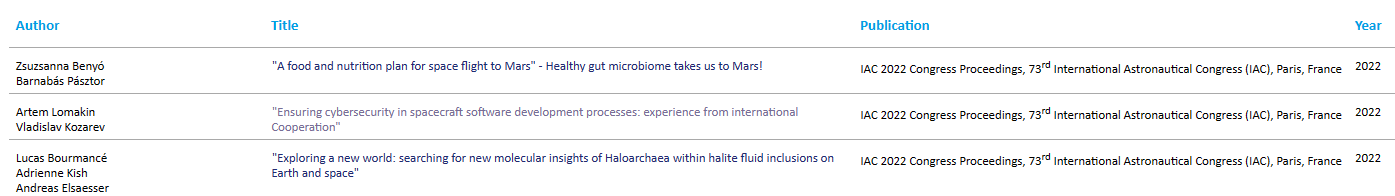



If I click on any of the abstracs, the following information is provided: author, year, country, organisation, title, and abstract.


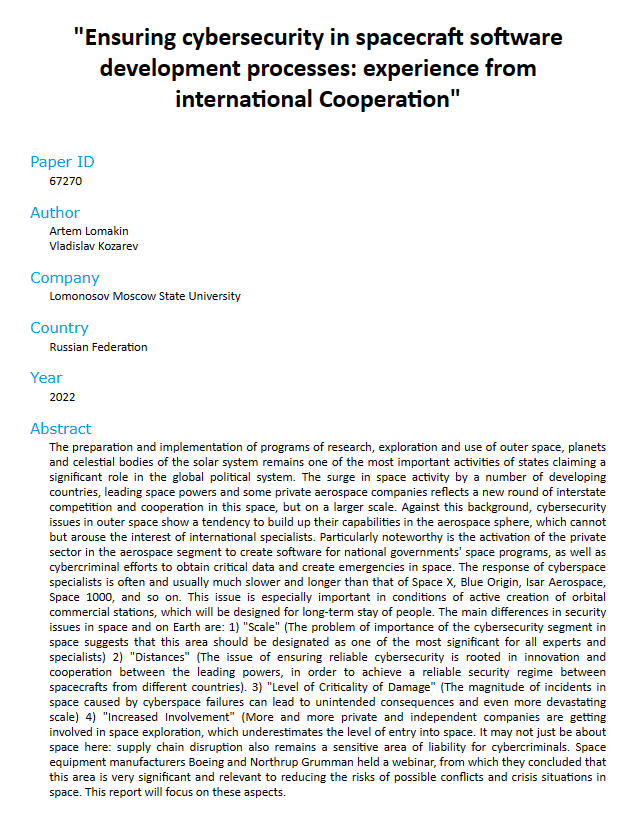

In the code below, I'll download all the abstracts and the associated information (e.g., country) from the past five years. Having a longer time period will allow to analyse trends over time. Finally, I store the data in a dict and pickle it for the next step (pre-processing).

In [ ]:
from bs4 import BeautifulSoup
import requests
import re
import pickle

# 1. Navigating the main pages and extracting links
These are the main pages, each of which has 500 links to abstract-pages.

In [ ]:
##2022
list_of_pages_22 = ["https://dl.iafastro.directory/search/?q=event%3AIAC-2022&o=2000&l=500&o=0",
                    "https://dl.iafastro.directory/search/?q=event%3AIAC-2022&o=0&l=500&o=500",
                    "https://dl.iafastro.directory/search/?q=event%3AIAC-2022&o=500&l=500&o=1000",
                    "https://dl.iafastro.directory/search/?q=event%3AIAC-2022&o=1000&l=500&o=1500",
                    "https://dl.iafastro.directory/search/?q=event%3AIAC-2022&o=1500&l=500&o=2000",
                    "https://dl.iafastro.directory/search/?q=event%3AIAC-2022&o=2000&l=500&o=2500",
                    ]
##2021
list_of_pages_21 = ["https://dl.iafastro.directory/search/?q=event%3AIAC-2021&l=500",
                    "https://dl.iafastro.directory/search/?q=event%3AIAC-2021&o=0&l=500&o=500",
                    "https://dl.iafastro.directory/search/?q=event%3AIAC-2021&o=500&l=500&o=1000",
                    "https://dl.iafastro.directory/search/?q=event%3AIAC-2021&o=1000&l=500&o=1500"
                    ]
##2020
list_of_pages_20 = ["https://dl.iafastro.directory/search/?q=event%3AIAC-2020&l=500",
                    "https://dl.iafastro.directory/search/?q=event%3AIAC-2020&o=0&l=500&o=500",
                    "https://dl.iafastro.directory/search/?q=event%3AIAC-2020&o=500&l=500&o=1000",
                    "https://dl.iafastro.directory/search/?q=event%3AIAC-2020&o=1000&l=500&o=1500",
                    "https://dl.iafastro.directory/search/?q=event%3AIAC-2020&o=1500&l=500&o=2000",
                    ]
##2019
list_of_pages_19 = ["https://dl.iafastro.directory/search/?q=event%3AIAC-2019&l=500",
                    "https://dl.iafastro.directory/search/?q=event%3AIAC-2019&o=0&l=500&o=500",
                    "https://dl.iafastro.directory/search/?q=event%3AIAC-2019&o=500&l=500&o=1000",
                    "https://dl.iafastro.directory/search/?q=event%3AIAC-2019&o=1000&l=500&o=1500",
                    ]
##2018
list_of_pages_18 = ["https://dl.iafastro.directory/search/?q=event%3AIAC-2018&o=0&l=10&l=500",
                    "https://dl.iafastro.directory/search/?q=event%3AIAC-2018&o=0&l=500&o=500",
                    "https://dl.iafastro.directory/search/?q=event%3AIAC-2018&o=500&l=500&o=1000",
                    "https://dl.iafastro.directory/search/?q=event%3AIAC-2018&o=1000&l=500&o=1500",
                    "https://dl.iafastro.directory/search/?q=event%3AIAC-2018&o=1500&l=500&o=2000"
                    ]

In [ ]:
##Dict to include the lists above
dict_of_pages = {2018: list_of_pages_18,
                 2019: list_of_pages_19,
                 2020: list_of_pages_20,
                 2021: list_of_pages_21,
                 2022: list_of_pages_22,
                 }

# 2. Extracting the links from the main pages

Each link contained in dict_of_pages contains 500 links to abstract pages (where the abstract and associated information is shown). This code opens each of the main pages stored in dict_of_pages and extracts the links to the abstract pages. Using regex avoids adding links that do not lead to an abstract page. All links are stored in the dict_of_links.

In [ ]:
dict_of_links = {}
for key, value in dict_of_pages.items():
  dict_of_links.update({key: {}})
  for url in value:
    counter = 0
    result = requests.get(url)
    doc = BeautifulSoup(result.text, "html.parser")
    tag = doc.find_all("a")
    for element in tag:
      if re.match("../event/IAC", tag[counter]["href"]):
        dict_of_links[key].update({tag[counter].text: tag[counter]["href"]})
      counter +=1
  counter = 0

#dict_of_links

# 3. Extracting info

Now that we have all links that lead to abstract pages, it's time to extract all the relevant information from them. The code below iterates over the links in dict_of_links and extracts all the information and stores it in dict_of_info.

In [ ]:
dict_of_info = {}

iteration = 0 #I'm only using the iteration to track progress because this takes a while to execute

for key, value in dict_of_links.items():
  dict_of_info.update({key: {}})
  for year, link in dict_of_links[key].items():

    iteration +=1
    if iteration in [50, 100, 200, 500, 700, 1000, 1200, 1500, 1800, 2000, 2300, 2500]:
        progress = f"Progress: {iteration} / {len(dict_of_links[key])}"
        print(key, progress)

    url = re.sub("../event", "https://dl.iafastro.directory/event", link)
    html = requests.get(url).content
    unicode_string = html.decode("utf8") #decoding and encoding because some special characters were gibberish if these steps are skipped
    encoded_string = unicode_string.encode("ascii", "ignore")

    doc = BeautifulSoup(encoded_string, "html.parser")
    tag = doc.find_all("dd")
    try:
      dict_of_info[key].update({tag[0].text: { 
        "title" : re.sub("â\x80\x94 IAF Digital Library", "", doc.title.string),
        "paper_id": tag[0].text,
        "authors": [author.text for author in tag[1].find_all("li")],
        "company": tag[2].text,
        "country": tag[3].text,
        "year": tag[4].text,
        "link": url,
        "abstract": tag[5].text
      }})
    except IndexError:
      pass
    continue

  iteration = 0

# 4. Pickling the Result

In [ ]:
###pickling

#with open("IAC_raw_data.pickle", "wb") as handle:
  #pickle.dump(dict_of_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

Now we've downloaded all the data. It's pretty rough and cannot be analysed yet. One significant issue is that the information entered under "company" is not always uniform: an entry may be written as "European Space Agency" or "ESA" (and many more variants). In the next step, I pre-process the data to get it ready for analysis.